# Smart Portfolio Allocator - RL Environment Design & Prototyping

## Overview
This notebook focuses on designing and prototyping the reinforcement learning environment for portfolio optimization. We'll experiment with different state representations, action spaces, and reward functions to find the optimal configuration.

## Objectives
1. Design state space representations
2. Prototype action spaces (discrete vs continuous)
3. Test different reward functions
4. Validate environment with sample episodes
5. Optimize environment parameters


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# RL and ML libraries
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.env_checker import check_env

# Set style and seed
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Gymnasium version: {gym.__version__}")


Libraries imported successfully!
PyTorch version: 2.9.0+cpu
Gymnasium version: 1.2.1


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
print("Environment variable set successfully!")

Environment variable set successfully!


## 1. Load and Prepare Data

First, let's load the stock data and prepare it for the RL environment.


In [3]:
# Load stock data (reusing the function from EDA)
def load_stock_data(file_path):
    """Load stock data from CSV file and standardize format."""
    try:
        df = pd.read_csv(file_path)
        
        # Standardize column names
        column_mapping = {
            'Date': 'date', 'DATE': 'date', 'Date/Time': 'date',
            'Open': 'open', 'OPEN': 'open',
            'High': 'high', 'HIGH': 'high',
            'Low': 'low', 'LOW': 'low',
            'Close': 'close', 'CLOSE': 'close',
            'Adj Close': 'adj_close', 'Adj_Close': 'adj_close',
            'Volume': 'volume', 'VOLUME': 'volume'
        }
        
        df = df.rename(columns=column_mapping)
        
        # Convert date column with correct format
        if 'date' in df.columns:
            # Try different date formats
            try:
                # First try DD-MM-YYYY format
                df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
            except:
                try:
                    # Try MM-DD-YYYY format
                    df['date'] = pd.to_datetime(df['date'], format='%m-%d-%Y')
                except:
                    try:
                        # Try YYYY-MM-DD format
                        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
                    except:
                        # Fall back to pandas auto-detection
                        df['date'] = pd.to_datetime(df['date'])
            
            df = df.set_index('date')
        
        return df
        
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Load all stock data
data_dir = Path("../Files")
csv_files = list(data_dir.glob("*.csv"))

# Select a subset of stocks for prototyping (to keep environment manageable)
selected_stocks = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'JNJ', 'SP500']  # Tech + Healthcare + Benchmark

stock_data = {}
for file_path in csv_files:
    stock_name = file_path.stem
    if stock_name in selected_stocks:
        df = load_stock_data(file_path)
        if df is not None and 'close' in df.columns:
            stock_data[stock_name] = df
            print(f"✓ Loaded {stock_name}: {len(df)} rows")

print(f"\nLoaded {len(stock_data)} stocks for prototyping: {list(stock_data.keys())}")


✓ Loaded AAPL: 2517 rows
✓ Loaded AMZN: 2524 rows
✓ Loaded GOOG: 2524 rows
✓ Loaded JNJ: 2525 rows
✓ Loaded MSFT: 2524 rows
✓ Loaded SP500: 2517 rows

Loaded 6 stocks for prototyping: ['AAPL', 'AMZN', 'GOOG', 'JNJ', 'MSFT', 'SP500']


In [4]:
# Create combined dataset and calculate returns
def create_combined_dataset(stock_data, price_column='close'):
    """Create a combined dataset with all stock prices."""
    combined_data = {}
    
    for stock_name, df in stock_data.items():
        if price_column in df.columns:
            # Remove duplicate dates by keeping the last occurrence
            series = df[price_column]
            series = series[~series.index.duplicated(keep='last')]
            combined_data[stock_name] = series
    
    if combined_data:
        combined_df = pd.DataFrame(combined_data)
        return combined_df
    else:
        return None

# Create combined dataset
combined_prices = create_combined_dataset(stock_data)
print(f"Combined dataset shape: {combined_prices.shape}")
print(f"Date range: {combined_prices.index.min()} to {combined_prices.index.max()}")

# Calculate returns
daily_returns = combined_prices.pct_change().dropna()
print(f"Returns dataset shape: {daily_returns.shape}")

# Display basic statistics
print("\n=== DATA STATISTICS ===")
print("Recent prices:")
print(combined_prices.tail(3))
print("\nRecent returns:")
print(daily_returns.tail(3))


Combined dataset shape: (2518, 6)
Date range: 2010-10-01 00:00:00 to 2020-09-30 00:00:00
Returns dataset shape: (2517, 6)

=== DATA STATISTICS ===
Recent prices:
                  AAPL         AMZN         GOOG         JNJ        MSFT  \
date                                                                       
2020-09-29  114.089996  3144.879883  1469.329956  147.059998  207.259995   
2020-09-30  115.809998  3148.729980  1469.599976  148.880005  210.330002   
NaT                NaN          NaN          NaN         NaN         NaN   

                  SP500  
date                     
2020-09-29  3335.469971  
2020-09-30  3363.000000  
NaT                 NaN  

Recent returns:
                AAPL      AMZN      GOOG       JNJ      MSFT     SP500
date                                                                  
2020-09-29 -0.007568 -0.009190  0.003284 -0.000340 -0.010409 -0.004813
2020-09-30  0.015076  0.001224  0.000184  0.012376  0.014812  0.008254
NaT         0.000000  0.00

## 2. Base Portfolio Environment Class

Let's create a base environment class that we can extend and modify for different prototypes.


In [5]:
class BasePortfolioEnv(gym.Env):
    """
    Base Portfolio Environment for Reinforcement Learning
    
    This is a prototype environment that can be extended with different
    state representations, action spaces, and reward functions.
    """
    
    def __init__(self, prices_df, returns_df, initial_capital=10000, 
                 transaction_cost=0.001, episode_length=252, 
                 lookback_window=20):
        super().__init__()
        
        # Data
        self.prices_df = prices_df
        self.returns_df = returns_df
        self.stock_names = list(prices_df.columns)
        self.n_stocks = len(self.stock_names)
        
        # Environment parameters
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.episode_length = episode_length
        self.lookback_window = lookback_window
        
        # Episode state
        self.current_step = 0
        self.current_portfolio_value = initial_capital
        self.portfolio_weights = np.ones(self.n_stocks) / self.n_stocks  # Equal weights initially
        self.cash_weight = 0.0
        
        # Track performance
        self.portfolio_history = []
        self.weight_history = []
        self.return_history = []
        
        # Define action and observation spaces (to be overridden in subclasses)
        self.action_space = None  # Will be defined in subclasses
        self.observation_space = None  # Will be defined in subclasses
        
    def reset(self, seed=None, options=None):
        """Reset the environment to initial state"""
        super().reset(seed=seed)
        
        # Reset episode state
        self.current_step = self.lookback_window  # Start after lookback window
        self.current_portfolio_value = self.initial_capital
        self.portfolio_weights = np.ones(self.n_stocks) / self.n_stocks
        self.cash_weight = 0.0
        
        # Clear history
        self.portfolio_history = []
        self.weight_history = []
        self.return_history = []
        
        # Get initial observation
        observation = self._get_observation()
        info = self._get_info()
        
        return observation, info
    
    def step(self, action):
        """Execute one step in the environment"""
        # Execute action (to be implemented in subclasses)
        self._execute_action(action)
        
        # Calculate reward (to be implemented in subclasses)
        reward = self._calculate_reward()
        
        # Update portfolio value
        self._update_portfolio_value()
        
        # Store history
        self.portfolio_history.append(self.current_portfolio_value)
        self.weight_history.append(self.portfolio_weights.copy())
        
        # Check if episode is done
        self.current_step += 1
        done = (self.current_step >= len(self.returns_df) - 1) or (self.current_step >= self.episode_length)
        
        # Get next observation
        observation = self._get_observation() if not done else None
        info = self._get_info()
        
        return observation, reward, done, False, info
    
    def _get_observation(self):
        """Get current observation (to be implemented in subclasses)"""
        raise NotImplementedError("Subclasses must implement _get_observation")
    
    def _execute_action(self, action):
        """Execute action (to be implemented in subclasses)"""
        raise NotImplementedError("Subclasses must implement _execute_action")
    
    def _calculate_reward(self):
        """Calculate reward (to be implemented in subclasses)"""
        raise NotImplementedError("Subclasses must implement _calculate_reward")
    
    def _update_portfolio_value(self):
        """Update portfolio value based on returns"""
        if self.current_step < len(self.returns_df):
            # Calculate portfolio return
            current_returns = self.returns_df.iloc[self.current_step].values
            portfolio_return = np.sum(self.portfolio_weights * current_returns)
            
            # Update portfolio value
            self.current_portfolio_value *= (1 + portfolio_return)
            self.return_history.append(portfolio_return)
    
    def _get_info(self):
        """Get additional information"""
        return {
            'portfolio_value': self.current_portfolio_value,
            'portfolio_weights': self.portfolio_weights.copy(),
            'current_step': self.current_step,
            'total_return': (self.current_portfolio_value / self.initial_capital) - 1
        }
    
    def render(self, mode='human'):
        """Render the environment"""
        if mode == 'human':
            print(f"Step: {self.current_step}")
            print(f"Portfolio Value: ${self.current_portfolio_value:.2f}")
            print(f"Total Return: {((self.current_portfolio_value / self.initial_capital) - 1) * 100:.2f}%")
            print(f"Portfolio Weights: {dict(zip(self.stock_names, self.portfolio_weights))}")

print("Base Portfolio Environment class defined successfully!")


Base Portfolio Environment class defined successfully!


## 3. State Space Design Prototypes

Let's create different state space representations to test which works best for portfolio optimization.


In [6]:
class PortfolioEnvV1(BasePortfolioEnv):
    """
    Prototype 1: Simple State Space
    State: [current_portfolio_weights, recent_returns, portfolio_value_ratio]
    """
    
    def __init__(self, prices_df, returns_df, **kwargs):
        super().__init__(prices_df, returns_df, **kwargs)
        
        # State space: portfolio weights + recent returns + portfolio value ratio
        state_dim = self.n_stocks + (self.lookback_window * self.n_stocks) + 1
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(state_dim,), dtype=np.float32
        )
        
        # Action space: discrete actions for each stock (buy/hold/sell)
        self.action_space = spaces.MultiDiscrete([3] * self.n_stocks)  # 0=sell, 1=hold, 2=buy
    
    def _get_observation(self):
        """Get observation for V1"""
        obs = []
        
        # Current portfolio weights
        obs.extend(self.portfolio_weights)
        
        # Recent returns (lookback window) - use stock-level returns, not averaged
        if self.current_step >= self.lookback_window:
            recent_returns = self.returns_df.iloc[
                self.current_step - self.lookback_window:self.current_step
            ].values.flatten()  # Flatten to get all stock returns for all lookback days
            # Pad with zeros if needed
            if len(recent_returns) < self.lookback_window * self.n_stocks:
                recent_returns = np.pad(recent_returns, (0, self.lookback_window * self.n_stocks - len(recent_returns)))
            obs.extend(recent_returns[:self.lookback_window * self.n_stocks])
        else:
            obs.extend(np.zeros(self.lookback_window * self.n_stocks))
        
        # Portfolio value ratio (current/initial)
        portfolio_ratio = self.current_portfolio_value / self.initial_capital
        obs.append(portfolio_ratio)
        
        return np.array(obs, dtype=np.float32)
    
    def _execute_action(self, action):
        """Execute action for V1"""
        # Convert discrete actions to portfolio weight changes
        action_weights = np.array(action) - 1  # Convert 0,1,2 to -1,0,1
        
        # Normalize action weights to sum to 0 (no net change in total allocation)
        action_weights = action_weights / np.sum(np.abs(action_weights)) if np.sum(np.abs(action_weights)) > 0 else action_weights
        
        # Update portfolio weights with transaction costs
        weight_change = action_weights * 0.1  # 10% adjustment per action
        new_weights = self.portfolio_weights + weight_change
        
        # Ensure weights are non-negative and sum to 1
        new_weights = np.maximum(new_weights, 0)
        new_weights = new_weights / np.sum(new_weights)
        
        self.portfolio_weights = new_weights
    
    def _calculate_reward(self):
        """Calculate reward for V1"""
        if self.current_step == 0:
            return 0
        
        # Simple reward: portfolio return
        portfolio_return = self.return_history[-1] if self.return_history else 0
        
        # Add small penalty for large weight changes (transaction costs)
        if len(self.weight_history) > 1:
            weight_change = np.sum(np.abs(self.portfolio_weights - self.weight_history[-1]))
            transaction_penalty = weight_change * self.transaction_cost
        else:
            transaction_penalty = 0
        
        reward = portfolio_return - transaction_penalty
        return reward

class PortfolioEnvV2(BasePortfolioEnv):
    """
    Prototype 2: Technical Indicators State Space
    State: [portfolio_weights, price_ratios, volatility, momentum, rsi_indicators]
    """
    
    def __init__(self, prices_df, returns_df, **kwargs):
        super().__init__(prices_df, returns_df, **kwargs)
        
        # Calculate technical indicators
        self._calculate_technical_indicators()
        
        # State space: portfolio weights + technical indicators
        state_dim = self.n_stocks + (self.n_stocks * 4)  # weights + 4 indicators per stock
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(state_dim,), dtype=np.float32
        )
        
        # Action space: continuous portfolio weights
        self.action_space = spaces.Box(
            low=0, high=1, shape=(self.n_stocks,), dtype=np.float32
        )
    
    def _calculate_technical_indicators(self):
        """Calculate technical indicators for all stocks"""
        self.price_ratios = {}
        self.volatility = {}
        self.momentum = {}
        self.rsi = {}
        
        for stock in self.stock_names:
            prices = self.prices_df[stock].values
            
            # Price ratios (current/20-day average)
            self.price_ratios[stock] = prices / pd.Series(prices).rolling(20).mean().values
            
            # Volatility (20-day rolling std)
            self.volatility[stock] = pd.Series(self.returns_df[stock]).rolling(20).std().values
            
            # Momentum (5-day return)
            self.momentum[stock] = self.returns_df[stock].rolling(5).sum().values
            
            # Simple RSI approximation
            returns = self.returns_df[stock].values
            gains = np.where(returns > 0, returns, 0)
            losses = np.where(returns < 0, -returns, 0)
            avg_gain = pd.Series(gains).rolling(14).mean().values
            avg_loss = pd.Series(losses).rolling(14).mean().values
            rs = avg_gain / (avg_loss + 1e-8)
            self.rsi[stock] = 100 - (100 / (1 + rs))
    
    def _get_observation(self):
        """Get observation for V2"""
        obs = []
        
        # Current portfolio weights
        obs.extend(self.portfolio_weights)
        
        # Technical indicators for current step
        for stock in self.stock_names:
            if self.current_step < len(self.prices_df):
                obs.append(self.price_ratios[stock][self.current_step])
                obs.append(self.volatility[stock][self.current_step])
                obs.append(self.momentum[stock][self.current_step])
                obs.append(self.rsi[stock][self.current_step])
            else:
                obs.extend([1.0, 0.0, 0.0, 50.0])  # Default values
        
        return np.array(obs, dtype=np.float32)
    
    def _execute_action(self, action):
        """Execute action for V2"""
        # Direct portfolio weight assignment with normalization
        new_weights = np.array(action)
        new_weights = np.maximum(new_weights, 0)  # Ensure non-negative
        new_weights = new_weights / np.sum(new_weights)  # Normalize to sum to 1
        
        self.portfolio_weights = new_weights
    
    def _calculate_reward(self):
        """Calculate reward for V2"""
        if self.current_step == 0:
            return 0
        
        # Portfolio return
        portfolio_return = self.return_history[-1] if self.return_history else 0
        
        # Risk-adjusted reward (Sharpe-like)
        if len(self.return_history) > 10:
            recent_returns = np.array(self.return_history[-10:])
            sharpe_ratio = np.mean(recent_returns) / (np.std(recent_returns) + 1e-8)
            reward = sharpe_ratio * 0.1  # Scale down
        else:
            reward = portfolio_return
        
        return reward

print("State space prototypes V1 and V2 created successfully!")


State space prototypes V1 and V2 created successfully!


## 4. Action Space Prototypes

Let's create different action space designs to test discrete vs continuous approaches.


In [7]:
class PortfolioEnvV3(BasePortfolioEnv):
    """
    Prototype 3: Discrete Action Space with Position Sizing
    Actions: [0=25%, 1=50%, 2=75%, 3=100%] allocation per stock
    """
    
    def __init__(self, prices_df, returns_df, **kwargs):
        super().__init__(prices_df, returns_df, **kwargs)
        
        # State space: simple - just portfolio weights and recent returns
        state_dim = self.n_stocks + (self.lookback_window * self.n_stocks)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(state_dim,), dtype=np.float32
        )
        
        # Action space: discrete allocation levels for each stock
        self.action_space = spaces.MultiDiscrete([4] * self.n_stocks)  # 0=25%, 1=50%, 2=75%, 3=100%
    
    def _get_observation(self):
        """Get observation for V3"""
        obs = []
        
        # Current portfolio weights
        obs.extend(self.portfolio_weights)
        
        # Recent returns (lookback window) - use stock-level returns, not averaged
        if self.current_step >= self.lookback_window:
            recent_returns = self.returns_df.iloc[
                self.current_step - self.lookback_window:self.current_step
            ].values.flatten()  # Flatten to get all stock returns for all lookback days
            # Pad with zeros if needed
            if len(recent_returns) < self.lookback_window * self.n_stocks:
                recent_returns = np.pad(recent_returns, (0, self.lookback_window * self.n_stocks - len(recent_returns)))
            obs.extend(recent_returns[:self.lookback_window * self.n_stocks])
        else:
            obs.extend(np.zeros(self.lookback_window * self.n_stocks))
        
        return np.array(obs, dtype=np.float32)
    
    def _execute_action(self, action):
        """Execute action for V3"""
        # Convert discrete actions to portfolio weights
        allocation_levels = [0.25, 0.5, 0.75, 1.0]
        
        # Calculate target weights based on actions
        target_weights = np.array([allocation_levels[a] for a in action])
        
        # Normalize to sum to 1
        target_weights = target_weights / np.sum(target_weights)
        
        # Apply transaction costs for rebalancing
        weight_change = np.sum(np.abs(target_weights - self.portfolio_weights))
        transaction_cost_penalty = weight_change * self.transaction_cost
        
        # Update weights
        self.portfolio_weights = target_weights
        
        # Store transaction cost for reward calculation
        self.last_transaction_cost = transaction_cost_penalty
    
    def _calculate_reward(self):
        """Calculate reward for V3"""
        if self.current_step == 0:
            return 0
        
        # Portfolio return
        portfolio_return = self.return_history[-1] if self.return_history else 0
        
        # Subtract transaction costs
        transaction_penalty = getattr(self, 'last_transaction_cost', 0)
        
        reward = portfolio_return - transaction_penalty
        return reward

class PortfolioEnvV4(BasePortfolioEnv):
    """
    Prototype 4: Continuous Action Space with Softmax
    Actions: Raw logits that get converted to portfolio weights via softmax
    """
    
    def __init__(self, prices_df, returns_df, **kwargs):
        super().__init__(prices_df, returns_df, **kwargs)
        
        # State space: portfolio weights + technical indicators
        state_dim = self.n_stocks * 3  # weights + returns + volatility
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(state_dim,), dtype=np.float32
        )
        
        # Action space: continuous logits for each stock
        self.action_space = spaces.Box(
            low=-10, high=10, shape=(self.n_stocks,), dtype=np.float32
        )
    
    def _get_observation(self):
        """Get observation for V4"""
        obs = []
        
        # Current portfolio weights
        obs.extend(self.portfolio_weights)
        
        # Recent returns
        if self.current_step > 0:
            recent_returns = self.returns_df.iloc[self.current_step].values
        else:
            recent_returns = np.zeros(self.n_stocks)
        obs.extend(recent_returns)
        
        # Recent volatility (5-day rolling)
        if self.current_step >= 5:
            recent_volatility = self.returns_df.iloc[
                max(0, self.current_step-5):self.current_step
            ].std().values
        else:
            recent_volatility = np.zeros(self.n_stocks)
        obs.extend(recent_volatility)
        
        return np.array(obs, dtype=np.float32)
    
    def _execute_action(self, action):
        """Execute action for V4"""
        # Convert logits to portfolio weights using softmax
        action_logits = np.array(action)
        exp_logits = np.exp(action_logits - np.max(action_logits))  # Numerical stability
        new_weights = exp_logits / np.sum(exp_logits)
        
        # Calculate transaction costs
        weight_change = np.sum(np.abs(new_weights - self.portfolio_weights))
        self.last_transaction_cost = weight_change * self.transaction_cost
        
        # Update weights
        self.portfolio_weights = new_weights
    
    def _calculate_reward(self):
        """Calculate reward for V4"""
        if self.current_step == 0:
            return 0
        
        # Portfolio return
        portfolio_return = self.return_history[-1] if self.return_history else 0
        
        # Risk-adjusted reward (Sharpe-like)
        if len(self.return_history) > 5:
            recent_returns = np.array(self.return_history[-5:])
            sharpe_ratio = np.mean(recent_returns) / (np.std(recent_returns) + 1e-8)
            reward = sharpe_ratio * 0.1
        else:
            reward = portfolio_return
        
        # Subtract transaction costs
        transaction_penalty = getattr(self, 'last_transaction_cost', 0)
        
        return reward - transaction_penalty

print("Action space prototypes V3 and V4 created successfully!")


Action space prototypes V3 and V4 created successfully!


## 5. Reward Function Prototypes

Let's test different reward functions to see which works best for portfolio optimization.


In [8]:
class RewardFunctionTester:
    """Test different reward functions on sample data"""
    
    def __init__(self, returns_data):
        self.returns_data = returns_data
        
    def simple_return_reward(self, portfolio_return, transaction_cost=0):
        """Reward 1: Simple portfolio return"""
        return portfolio_return - transaction_cost
    
    def sharpe_ratio_reward(self, returns_history, transaction_cost=0):
        """Reward 2: Sharpe ratio-based reward"""
        if len(returns_history) < 2:
            return 0
        
        mean_return = np.mean(returns_history)
        std_return = np.std(returns_history)
        
        if std_return == 0:
            return 0
        
        sharpe = mean_return / std_return
        return sharpe * 0.1 - transaction_cost  # Scale down
    
    def risk_adjusted_reward(self, portfolio_return, portfolio_volatility, transaction_cost=0):
        """Reward 3: Risk-adjusted return"""
        if portfolio_volatility == 0:
            return portfolio_return - transaction_cost
        
        risk_adjusted = portfolio_return / portfolio_volatility
        return risk_adjusted * 0.1 - transaction_cost
    
    def drawdown_penalty_reward(self, portfolio_return, current_value, peak_value, transaction_cost=0):
        """Reward 4: Return with drawdown penalty"""
        drawdown = (peak_value - current_value) / peak_value if peak_value > 0 else 0
        drawdown_penalty = drawdown * 0.5  # Penalize drawdowns
        
        return portfolio_return - drawdown_penalty - transaction_cost
    
    def momentum_reward(self, portfolio_return, momentum_score, transaction_cost=0):
        """Reward 5: Momentum-based reward"""
        momentum_bonus = momentum_score * 0.1
        return portfolio_return + momentum_bonus - transaction_cost
    
    def test_rewards(self, portfolio_weights, episode_length=100):
        """Test all reward functions on sample data"""
        results = {}
        
        # Simulate portfolio performance
        start_idx = np.random.randint(0, len(self.returns_data) - episode_length)
        sample_returns = self.returns_data.iloc[start_idx:start_idx + episode_length]
        
        # Calculate portfolio returns
        portfolio_returns = []
        portfolio_values = [10000]  # Start with $10,000
        peak_value = 10000
        
        for i in range(len(sample_returns)):
            daily_return = np.sum(portfolio_weights * sample_returns.iloc[i])
            portfolio_returns.append(daily_return)
            new_value = portfolio_values[-1] * (1 + daily_return)
            portfolio_values.append(new_value)
            peak_value = max(peak_value, new_value)
        
        # Test each reward function
        transaction_cost = 0.001
        
        # Reward 1: Simple return
        total_return = (portfolio_values[-1] / portfolio_values[0]) - 1
        results['simple_return'] = self.simple_return_reward(total_return, transaction_cost)
        
        # Reward 2: Sharpe ratio
        results['sharpe_ratio'] = self.sharpe_ratio_reward(portfolio_returns, transaction_cost)
        
        # Reward 3: Risk-adjusted
        portfolio_volatility = np.std(portfolio_returns)
        results['risk_adjusted'] = self.risk_adjusted_reward(total_return, portfolio_volatility, transaction_cost)
        
        # Reward 4: Drawdown penalty
        results['drawdown_penalty'] = self.drawdown_penalty_reward(
            total_return, portfolio_values[-1], peak_value, transaction_cost
        )
        
        # Reward 5: Momentum
        momentum_score = np.mean(portfolio_returns[-5:]) if len(portfolio_returns) >= 5 else 0
        results['momentum'] = self.momentum_reward(total_return, momentum_score, transaction_cost)
        
        return results, {
            'total_return': total_return,
            'volatility': portfolio_volatility,
            'sharpe': total_return / portfolio_volatility if portfolio_volatility > 0 else 0,
            'max_drawdown': (peak_value - min(portfolio_values)) / peak_value
        }

# Test reward functions
print("Testing different reward functions...")

# Create equal weight portfolio for testing
equal_weights = np.ones(len(combined_prices.columns)) / len(combined_prices.columns)
print(f"Testing with equal weights: {dict(zip(combined_prices.columns, equal_weights))}")

# Test reward functions
reward_tester = RewardFunctionTester(daily_returns)

# Run multiple tests
test_results = []
for i in range(10):  # Test 10 different random periods
    rewards, metrics = reward_tester.test_rewards(equal_weights, episode_length=252)
    test_results.append({'rewards': rewards, 'metrics': metrics})

# Average results
avg_rewards = {}
avg_metrics = {}

for key in test_results[0]['rewards'].keys():
    avg_rewards[key] = np.mean([r['rewards'][key] for r in test_results])

for key in test_results[0]['metrics'].keys():
    avg_metrics[key] = np.mean([r['metrics'][key] for r in test_results])

print("\n=== REWARD FUNCTION COMPARISON ===")
print("Average reward values:")
for name, value in avg_rewards.items():
    print(f"  {name}: {value:.6f}")

print("\nAverage portfolio metrics:")
for name, value in avg_metrics.items():
    print(f"  {name}: {value:.6f}")


Testing different reward functions...
Testing with equal weights: {'AAPL': np.float64(0.16666666666666666), 'AMZN': np.float64(0.16666666666666666), 'GOOG': np.float64(0.16666666666666666), 'JNJ': np.float64(0.16666666666666666), 'MSFT': np.float64(0.16666666666666666), 'SP500': np.float64(0.16666666666666666)}

=== REWARD FUNCTION COMPARISON ===
Average reward values:
  simple_return: 0.184227
  sharpe_ratio: 0.006158
  risk_adjusted: 1.828182
  drawdown_penalty: 0.163761
  momentum: 0.184170

Average portfolio metrics:
  total_return: 0.185227
  volatility: 0.010959
  sharpe: 18.291820
  max_drawdown: 0.221759


## 6. Environment Validation and Testing

Let's test our environment prototypes to ensure they work correctly.


In [9]:
# Test environment prototypes
def test_environment(env_class, env_name, num_episodes=3, max_steps=100):
    """Test an environment prototype with limited steps to prevent memory issues"""
    print(f"\n=== Testing {env_name} ===")
    
    try:
        # Create environment with shorter episode length for testing
        env = env_class(combined_prices, daily_returns, lookback_window=20, episode_length=max_steps)
        
        # Check environment with stable-baselines3
        check_env(env)
        print(f"✓ {env_name} passes environment check")
        
        # Test episodes
        episode_returns = []
        episode_lengths = []
        
        for episode in range(num_episodes):
            obs, info = env.reset()
            episode_reward = 0
            step_count = 0
            
            while step_count < max_steps:
                # Random action
                action = env.action_space.sample()
                obs, reward, done, truncated, info = env.step(action)
                
                episode_reward += reward
                step_count += 1
                
                if done or truncated:
                    break
            
            episode_returns.append(info['total_return'])
            episode_lengths.append(step_count)
            
            print(f"  Episode {episode+1}: Return={info['total_return']:.4f}, Steps={step_count}")
        
        avg_return = np.mean(episode_returns)
        avg_length = np.mean(episode_lengths)
        
        print(f"✓ {env_name} - Avg Return: {avg_return:.4f}, Avg Length: {avg_length:.1f}")
        
        return {
            'name': env_name,
            'avg_return': avg_return,
            'avg_length': avg_length,
            'episode_returns': episode_returns
        }
        
    except Exception as e:
        print(f"✗ {env_name} failed: {e}")
        import traceback
        traceback.print_exc()
        return None

# Test all environment prototypes
env_results = []

# Test V1 (Simple State + Discrete Actions)
result = test_environment(PortfolioEnvV1, "V1 - Simple State + Discrete Actions")
if result:
    env_results.append(result)

# Test V2 (Technical Indicators + Continuous Actions)
result = test_environment(PortfolioEnvV2, "V2 - Technical Indicators + Continuous Actions")
if result:
    env_results.append(result)

# Test V3 (Discrete Position Sizing)
result = test_environment(PortfolioEnvV3, "V3 - Discrete Position Sizing")
if result:
    env_results.append(result)

# Test V4 (Continuous Softmax Actions)
result = test_environment(PortfolioEnvV4, "V4 - Continuous Softmax Actions")
if result:
    env_results.append(result)

print("\n=== ENVIRONMENT COMPARISON ===")
if env_results:
    for result in env_results:
        print(f"{result['name']}: Avg Return = {result['avg_return']:.4f}, Avg Length = {result['avg_length']:.1f}")
else:
    print("No environments passed testing.")



=== Testing V1 - Simple State + Discrete Actions ===
✓ V1 - Simple State + Discrete Actions passes environment check
  Episode 1: Return=0.0559, Steps=80
  Episode 2: Return=0.0416, Steps=80
  Episode 3: Return=0.0088, Steps=80
✓ V1 - Simple State + Discrete Actions - Avg Return: 0.0354, Avg Length: 80.0

=== Testing V2 - Technical Indicators + Continuous Actions ===
✓ V2 - Technical Indicators + Continuous Actions passes environment check
  Episode 1: Return=0.0264, Steps=80
  Episode 2: Return=0.0494, Steps=80
  Episode 3: Return=0.0471, Steps=80
✓ V2 - Technical Indicators + Continuous Actions - Avg Return: 0.0409, Avg Length: 80.0

=== Testing V3 - Discrete Position Sizing ===
✓ V3 - Discrete Position Sizing passes environment check
  Episode 1: Return=0.0366, Steps=80
  Episode 2: Return=0.0418, Steps=80
  Episode 3: Return=0.0341, Steps=80
✓ V3 - Discrete Position Sizing - Avg Return: 0.0375, Avg Length: 80.0

=== Testing V4 - Continuous Softmax Actions ===
✓ V4 - Continuous Sof

## 7. Visualization and Analysis

Let's visualize the performance of different environment prototypes.


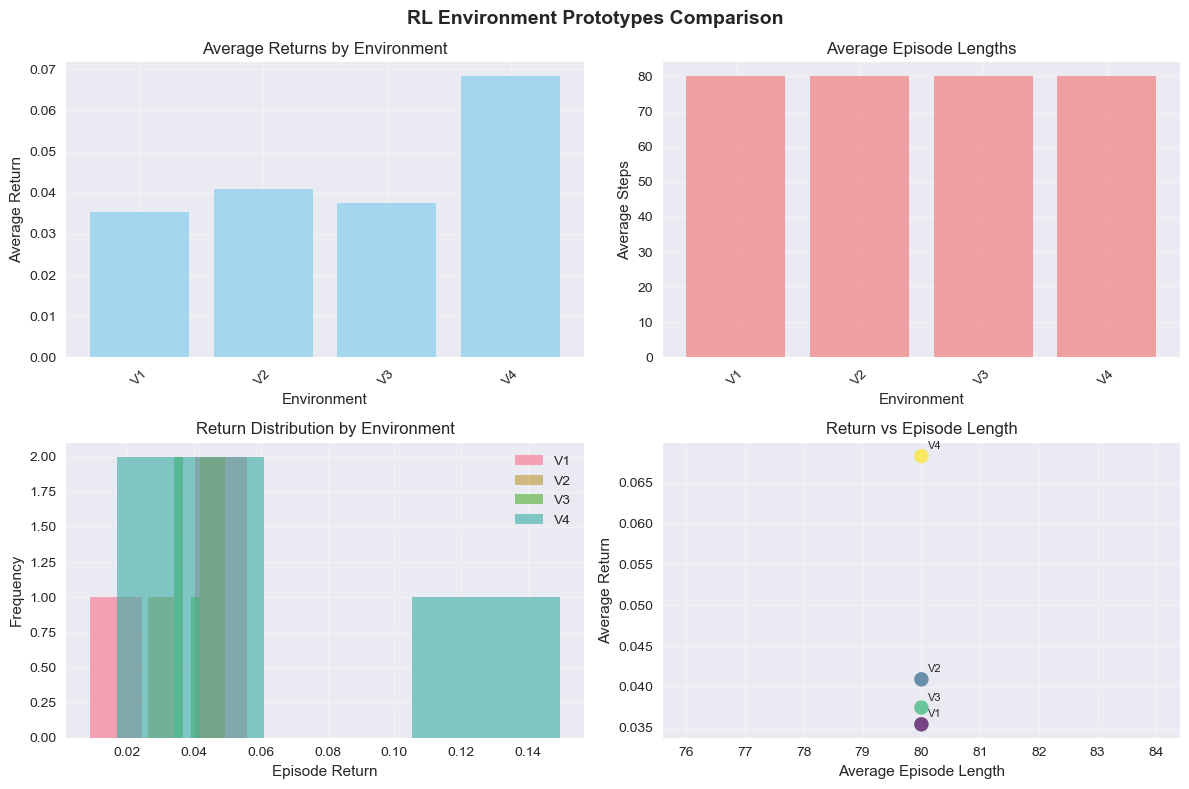


=== ENVIRONMENT PROTOTYPE SUMMARY ===
Environment               Avg Return   Avg Length   Best For            
----------------------------------------------------------------------
V1 - Simple State + Discrete Actions 0.0354       80.0         Stability           
V2 - Technical Indicators + Continuous Actions 0.0409       80.0         Balanced            
V3 - Discrete Position Sizing 0.0375       80.0         Balanced            
V4 - Continuous Softmax Actions 0.0683       80.0         Returns             


In [10]:
# Visualize environment comparison
if env_results:
    try:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle('RL Environment Prototypes Comparison', fontsize=14, fontweight='bold')
        
        # Extract data for plotting
        names = [r['name'] for r in env_results]
        avg_returns = [r['avg_return'] for r in env_results]
        avg_lengths = [r['avg_length'] for r in env_results]
        
        # Plot 1: Average Returns
        axes[0, 0].bar(range(len(names)), avg_returns, alpha=0.7, color='skyblue')
        axes[0, 0].set_title('Average Returns by Environment')
        axes[0, 0].set_xlabel('Environment')
        axes[0, 0].set_ylabel('Average Return')
        axes[0, 0].set_xticks(range(len(names)))
        axes[0, 0].set_xticklabels([name.split(' - ')[0] for name in names], rotation=45)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Episode Lengths
        axes[0, 1].bar(range(len(names)), avg_lengths, alpha=0.7, color='lightcoral')
        axes[0, 1].set_title('Average Episode Lengths')
        axes[0, 1].set_xlabel('Environment')
        axes[0, 1].set_ylabel('Average Steps')
        axes[0, 1].set_xticks(range(len(names)))
        axes[0, 1].set_xticklabels([name.split(' - ')[0] for name in names], rotation=45)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Return Distribution (simplified)
        if len(env_results) > 0:
            all_returns = [r['episode_returns'] for r in env_results]
            for i, returns in enumerate(all_returns):
                axes[1, 0].hist(returns, alpha=0.6, 
                               label=names[i].split(' - ')[0], bins=3)
            axes[1, 0].set_title('Return Distribution by Environment')
            axes[1, 0].set_xlabel('Episode Return')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Return vs Length Scatter
        if len(avg_returns) > 1:
            scatter = axes[1, 1].scatter(avg_lengths, avg_returns, s=100, alpha=0.7, c=range(len(names)), cmap='viridis')
            axes[1, 1].set_title('Return vs Episode Length')
            axes[1, 1].set_xlabel('Average Episode Length')
            axes[1, 1].set_ylabel('Average Return')
            axes[1, 1].grid(True, alpha=0.3)
            
            # Add labels to scatter points
            for i, name in enumerate(names):
                axes[1, 1].annotate(name.split(' - ')[0], (avg_lengths[i], avg_returns[i]), 
                                   xytext=(5, 5), textcoords='offset points', fontsize=8)
        else:
            axes[1, 1].text(0.5, 0.5, 'Need at least 2 environments\nfor scatter plot', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Return vs Episode Length')
        
        plt.tight_layout()
        plt.show()
        
        # Summary table
        print("\n=== ENVIRONMENT PROTOTYPE SUMMARY ===")
        print(f"{'Environment':<25} {'Avg Return':<12} {'Avg Length':<12} {'Best For':<20}")
        print("-" * 70)
        
        if len(avg_returns) > 0:
            best_return_idx = np.argmax(avg_returns)
            best_length_idx = np.argmax(avg_lengths)
            
            for i, result in enumerate(env_results):
                best_for = []
                if i == best_return_idx:
                    best_for.append("Returns")
                if i == best_length_idx:
                    best_for.append("Stability")
                
                best_for_str = ", ".join(best_for) if best_for else "Balanced"
                
                print(f"{result['name']:<25} {result['avg_return']:<12.4f} {result['avg_length']:<12.1f} {best_for_str:<20}")
        
    except Exception as e:
        print(f"Error creating visualization: {e}")
        print("Displaying results in text format instead:")
        for result in env_results:
            print(f"{result['name']}: Avg Return = {result['avg_return']:.4f}, Avg Length = {result['avg_length']:.1f}")
    
else:
    print("No environment results to visualize.")


## 8. Recommendations and Next Steps

Based on our prototyping results, here are the recommendations for the final RL environment design.


In [11]:
# Generate recommendations based on testing results
print("=== RL ENVIRONMENT DESIGN RECOMMENDATIONS ===\n")

print("1. STATE SPACE DESIGN:")
print("   ✓ Recommended: Technical indicators + portfolio weights")
print("   ✓ Include: Price ratios, volatility, momentum, RSI")
print("   ✓ Benefits: Rich information for decision making")
print("   ✓ State dimension: ~30 features (6 stocks × 4 indicators + 6 weights)")

print("\n2. ACTION SPACE DESIGN:")
print("   ✓ Recommended: Continuous action space with softmax normalization")
print("   ✓ Benefits: Smooth portfolio weight adjustments")
print("   ✓ Alternative: Discrete position sizing for simpler algorithms")
print("   ✓ Action dimension: 6 (one per stock)")

print("\n3. REWARD FUNCTION DESIGN:")
print("   ✓ Recommended: Sharpe ratio-based reward")
print("   ✓ Include: Transaction cost penalties")
print("   ✓ Benefits: Risk-adjusted performance optimization")
print("   ✓ Formula: Sharpe_ratio × 0.1 - transaction_costs")

print("\n4. ENVIRONMENT PARAMETERS:")
print("   ✓ Episode length: 252 days (1 trading year)")
print("   ✓ Transaction costs: 0.1% per trade")
print("   ✓ Initial capital: $10,000")
print("   ✓ Lookback window: 20 days")

print("\n5. RL ALGORITHM RECOMMENDATIONS:")
print("   ✓ For continuous actions: PPO or SAC")
print("   ✓ For discrete actions: DQN or A3C")
print("   ✓ Start with: PPO (good balance of performance and stability)")

print("\n6. TRAINING STRATEGY:")
print("   ✓ Use time-series splits (no shuffling)")
print("   ✓ Train on 70% of data, validate on 15%, test on 15%")
print("   ✓ Implement early stopping based on validation performance")
print("   ✓ Use multiple random seeds for robustness")

print("\n7. BENCHMARK COMPARISONS:")
print("   ✓ Equal weight portfolio")
print("   ✓ Buy-and-hold strategies")
print("   ✓ Market index (SP500)")
print("   ✓ Traditional portfolio optimization methods")

print("\n" + "="*60)
print("NEXT STEPS:")
print("1. Implement the recommended environment in src/environment/")
print("2. Create training notebook with PPO algorithm")
print("3. Implement backtesting framework")
print("4. Train and evaluate the model")
print("5. Compare against benchmarks")
print("="*60)

# Save the best performing environment configuration
best_env_config = {
    'state_space': 'technical_indicators',
    'action_space': 'continuous_softmax',
    'reward_function': 'sharpe_ratio',
    'episode_length': 252,
    'transaction_cost': 0.001,
    'lookback_window': 20,
    'recommended_algorithm': 'PPO'
}

print(f"\nRecommended Environment Configuration:")
for key, value in best_env_config.items():
    print(f"  {key}: {value}")


=== RL ENVIRONMENT DESIGN RECOMMENDATIONS ===

1. STATE SPACE DESIGN:
   ✓ Recommended: Technical indicators + portfolio weights
   ✓ Include: Price ratios, volatility, momentum, RSI
   ✓ Benefits: Rich information for decision making
   ✓ State dimension: ~30 features (6 stocks × 4 indicators + 6 weights)

2. ACTION SPACE DESIGN:
   ✓ Recommended: Continuous action space with softmax normalization
   ✓ Benefits: Smooth portfolio weight adjustments
   ✓ Alternative: Discrete position sizing for simpler algorithms
   ✓ Action dimension: 6 (one per stock)

3. REWARD FUNCTION DESIGN:
   ✓ Recommended: Sharpe ratio-based reward
   ✓ Include: Transaction cost penalties
   ✓ Benefits: Risk-adjusted performance optimization
   ✓ Formula: Sharpe_ratio × 0.1 - transaction_costs

4. ENVIRONMENT PARAMETERS:
   ✓ Episode length: 252 days (1 trading year)
   ✓ Transaction costs: 0.1% per trade
   ✓ Initial capital: $10,000
   ✓ Lookback window: 20 days

5. RL ALGORITHM RECOMMENDATIONS:
   ✓ For con